# Thermospheric Density Estimation Via Two-Line-Element Data Assimilation

1. Load TLE data. 
2. Load ballistic coefficient data. 
3. Generate observations from TLE data. 
4. Generate reduced-order density model.
5. Initialize reduced-order density state. 
6. Set initial orbital state guesses.
7. Set measurement and process noise, and initial state covariance. 
8. Run unscented Kalman filter to simultaneously estimate the orbital states, ballistic coefficients and thermospheric density from TLE-derived orbit observations.
9. (Optional) Save data for later analysis.
10. (Optional) Load previously saved data for analysis.
11. (Optional) Data visualization

In [1]:
## Import packages
import numpy as np
import datetime 
import spiceypy as spice
import scipy.io as sio
from python_utils.astro_function_jit import loc_gravLegendre_scaleFactor, inputEOP_Celestrak, loadSGP4, get_julian_datetime, inputSWnrlmsise, inputSWtiegcm, inputEOP_Celestrak_Full, readSOLFSMY
from python_utils.astro_function_jit import generateObservationsMEE, generateROMdensityModel, getDensityJB2008llajd, ep2pv_jit, UKF, readDTCFILE, from_jd, getTLEsForEstimation

import os 
import matplotlib.pyplot as plt
%matplotlib inline 

os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'

### SETTINGS
Specify the date, reduced-order model, reduction order and objects to be
used to estimation here.


In [2]:
# Estimation window
yr      = 2020; # Year
mth     = 1;    # Month
dy      = 3;    # Day
nofDays = 1;   # Number of days
nofHours = 0;  # Number of hours

# Use high fidelity dynamical model
highFidelity = True;

# Reduced-order model
ROMmodel = 'JB2008_1999_2010';  # Name of reduced-order density model: JB2008_1999_2010, NRLMSISE_1997_2008 or TIEGCM_1997_2008
r  = 10;                        # Reduced order

# NORAD catalog IDs of objects used for estimation
# 20 objects : Jan 3-28, 2020
selectedObjects = (22,614,932,1807,2153,2389,4221,4382,7337,8744,12138,12388,14483,20774,23278,41771,41772,41773,42989,43797);


### LOAD KERNELS, GRAVITY MODEL, EARTH ORIENTATION PARAMETERS AND SGP4

In [3]:
# Load SPICE kernels and ephemerides
spice.furnsh("Data/kernel.txt")

# Load gravity model
if highFidelity:
    gravmodeldegree  = 48;  # Use degree and order 48 for the spherical harmonics
else:
    gravmodeldegree  = 20;  # Use degree and order 20 for the spherical harmonics

# loads gravity model.
EGM2008 = sio.loadmat('Data/EGM2008.mat')
#,'GM', 'Re', 'degree', 'C', 'S'); # [GM, Re, degree, C, S]

GM = EGM2008['GM']
Re = EGM2008['Re']
degree = EGM2008['degree']
C = EGM2008['C']
S = EGM2008['S']

if gravmodeldegree > degree:
    print('Degree must be less than or equal to maximum degree of EGM2008 model. ',
        'Setting maximum degree to the maximum degree of the EGM2008 model.');
    gravmodeldegree = degree;
    
gravdegree = gravmodeldegree;
C_gravmodel = C[0:gravmodeldegree+2,0:gravmodeldegree+2];
S_gravmodel = S[0:gravmodeldegree+2,0:gravmodeldegree+2];

sF_gravmod = loc_gravLegendre_scaleFactor(gravmodeldegree);

# Set Earth constants
gravconst    = 6.67259e-20; # [km^3/kg/s^2]
Earth_radius = Re/1e3; # [km]
Earth_mass   = GM*1e-9/gravconst; # [kg]

# Load Earth orientation parameters (needed for TEME to ECI transformation)
EOPMat = inputEOP_Celestrak( "Data/EOP-All.txt" );

[tumin, mu, radiusearthkm, xke, j2, j3, j4, j3oj2, opsmode, whichconst] = loadSGP4()

In [4]:
GM_kms = GM*1e-9; # Earth gravitational parameter according to accurate gravity model [km^3 s^-2]

## Datetime
# Always start at midnight
hr=0; mn=0; sc=0; 

jd0 = get_julian_datetime(datetime.datetime(yr,mth,dy,0,0,0));
jdf = get_julian_datetime(datetime.datetime(yr,mth,dy+nofDays,nofHours,0,0));

# Time Interval for measurements
dt = 3600;
tf = (jdf-jd0)*24*60*60;
time = np.arange(0,tf+dt,dt); 
m=len(time);

## Load space weather data
SWpath = 'Data/SW-All.txt';
[ SWmatDaily, SWmatMonthlyPred ] = inputSWnrlmsise( SWpath );
[ SWmatDailyTIEGCM, SWmatMonthlyPredTIEGCM ] = inputSWtiegcm( SWpath );

## Load space weather data and Earth orientation parameters needed for JB2008 density model from file
# Read Earth orientation parameters
eopdata = inputEOP_Celestrak_Full('Data/EOP-All.txt');

# Read space weather data: solar activity indices
SOLdata = readSOLFSMY('Data/SOLFSMY.txt');

# Read geomagnetic storm DTC values
DTCdata = readDTCFILE('Data/DTCFILE.txt');

## Load TLE data

In [5]:
# Load a bit more TLEs than needed to plot the TLE data 
maxAlt = 10000; # Maximum altitude of apogee [km], TLEs for objects with higher apogee will not be downloaded
jdate0TLEs = get_julian_datetime(datetime.datetime(yr,mth,1,0,0,0)); # Start date of TLE collection window 
dt_jdf = from_jd(jdf+30);  # End date of TLE collection window 
yrf = dt_jdf.year
mthf = dt_jdf.month
dyf = dt_jdf.day

# Read downloaded TLE data
getTLEsFromSingleFile = True; # If true: all TLEs are loaded from file named "estimationObjects.tle" else TLEs are loaded from individual files named "[NORADID].tle"
objects, TLE_jdsatepoch = getTLEsForEstimation(yr, mth, 1, yrf, mthf, dyf, selectedObjects);

## Load Ballistic Coefficient data

In [6]:
# Ballistic coefficient data: NORAD ID and BC
filename = 'Data/BCdata.txt'
BCdata = np.loadtxt(filename, delimiter="\t",skiprows=2)

BCestimates = np.zeros((len(selectedObjects),1))
for ik in range(0,len(selectedObjects)):
    # Ballistic coefficient
    BCestimates[ik] = BCdata[BCdata[:,0]==selectedObjects[ik],1]
    
# Number of objects
nop = len(objects);

# Cell with object ID text strings
objectIDlabels = list(objects.keys())

## Generate observations from TLE data

In [7]:
obsEpochs = np.arange(jd0,jdf+dt/86400,dt/86400);
meeMeas = generateObservationsMEE(objects,TLE_jdsatepoch,obsEpochs,GM_kms,EOPMat);

## Generate reduced-order density model

In [8]:
## Load reduced-order density models
AC,BC,Uh,F_U,Dens_Mean,M_U,SLTm,LATm,ALTm,maxAtmAlt,SWinputs,Qrom = generateROMdensityModel(ROMmodel,r,jd0,jdf,spice)

## Initialize reduced order density state

In [9]:
# Use orbital state from TLE as initial orbital state guess
x0orbits = meeMeas[:,0];

# Size of state vector for each object [3xpos,3xvel,1xBC]
svs = 7;

# Initial state guess: Orbits, BCs and reduced order density
x0g = np.zeros((svs*nop+r,1));
for i in range (0,nop):
    # Orbital state guesses
    x0g[svs*(i):svs*(i)+6,0] = x0orbits[6*(i):6*(i)+6];
    # Ballistic coefficient guesses
    x0g[svs*(i+1)-1] = BCestimates[i] * 1000;
    
# Compute the initial atmosphere state from JB2008 density model
# Seconds of day in UTC
UT = hr*3600+mn*60+sc;

# Grid points of ROM model
sltx = np.reshape(np.swapaxes(SLTm,0,1),(SLTm.shape[0]*SLTm.shape[1]*SLTm.shape[2],1), order='F');
latx = np.reshape(np.swapaxes(LATm,0,1),(SLTm.shape[0]*SLTm.shape[1]*SLTm.shape[2],1), order='F');
altx = np.reshape(ALTm,(SLTm.shape[0]*SLTm.shape[1]*SLTm.shape[2],1), order='F');

# Density at grid points according to JB2008 density model
Dens_JB2008 = np.zeros((len(sltx),1));
for i in range(0,len(sltx)):
    # Geographical longitude
    lon = 15*(sltx[i]-UT/3600);
    # Density from JB2008 density model
    Dens_JB2008[i,0] = getDensityJB2008llajd(lon,latx[i],altx[i],jd0,eopdata,SOLdata,DTCdata,spice) * 1e-9;

# Initialize state for ROM using JB2008
z0_M = Uh.T@(np.log10(Dens_JB2008)-Dens_Mean); # JB2008 initialization

# Add initial ROM state to initial state guess
x0g[-r:,0] = z0_M.flatten();

## Set initial orbital state guesses

In [10]:
## Density estimation
# State estimate
X_est = x0g; # Initial state guess

# Initial Ephemeris Time (ET): ET is the number of seconds past the 
# epoch of the J2000 reference frame in the time system known as 
# Barycentric Dynamical Time (TDB).
et0  = spice.spiceypy.str2et(from_jd(jd0).strftime("%Y %m %d %H %M %S"))

## Set measurement and process noise, and initial state covariance

In [11]:
## Measurements and covariance
# TLE-derived orbit observations in modified equinoctial elements
Meas = meeMeas;

# Measurement noise
RM = [];
for i in range (0,nop):
    RMfactor = np.amax((objects[objectIDlabels[i]][0][0].ecco/0.004,1))
    RM = np.hstack((RM, np.amax((4*objects[objectIDlabels[i]][0][0].ecco,0.0023)), RMfactor*3.0e-10, RMfactor*3.0e-10, 1.e-9, 1.e-9, 1e-8));

RM = np.diag(RM); # Convert to matrix with variances on the diagonal

## Process noise Q and initial state covariance P
Pv = np.zeros((svs*nop+r,1)); # state variance
Qv = np.zeros((svs*nop+r,1)); # process variance
for i in range(0,nop):
    # Initial variance for orbital state in MEE (equal to measurement noise)
    Pv[svs*(i)+0] = RM[6*(i)+0,6*(i)+0];
    Pv[svs*(i)+1] = RM[6*(i)+1,6*(i)+1];
    Pv[svs*(i)+2] = RM[6*(i)+2,6*(i)+2];
    Pv[svs*(i)+3] = RM[6*(i)+3,6*(i)+3];
    Pv[svs*(i)+4] = RM[6*(i)+4,6*(i)+4];
    Pv[svs*(i)+5] = RM[6*(i)+5,6*(i)+5];

    # Initial variance for ballistic coefficient
    Pv[svs*(i)+6] = (x0g[svs*(i)+6] * 0.01)**2; # 1# BC 1-sigma error

    # Process noise for orbital state in MEE
    Qv[svs*(i)+0] = 1.5e-8; 
    Qv[svs*(i)+1] = 2e-14; 
    Qv[svs*(i)+2] = 2e-14; 
    Qv[svs*(i)+3] = 1e-14; 
    Qv[svs*(i)+4] = 1e-14; 
    Qv[svs*(i)+5] = 1e-12;

    # Process noise for ballistic coefficient
    Qv[svs*(i)+6] = 1e-16; # 1-sigma error: 1e-8 per 1 hour

# Initial variance for reduced-order density state
Pv[-r:] = (5e0)*np.ones((r,1));
Pv[-r] = 2e1; # First mode

# Process noise for reduced-order density state
# Use variance of ROM model 1-hour prediction error w.r.t. the training data
Qv[-r:] = np.diag(Qrom).reshape(r,1);

# Initial state covariance and process noise matrices
P = np.diag(Pv.flatten()); # Convert to matrix with variances on the diagonal
Q = np.diag(Qv.flatten()); # Convert to matrix with variances on the diagonal
    

## Run unscented Kalman filter 

In [12]:
# Run Unscented Kalman filter estimation
X_est,Pv = UKF(X_est,Meas,time,P,RM,Q,nop,svs,r, AC, BC, SWinputs, F_U, M_U, maxAtmAlt, et0, jd0, highFidelity, GM, Re, C_gravmodel,S_gravmodel, gravdegree, sF_gravmod)
Pv[:,0] = np.diag(P); # Add initial state variance to state variance history

0 24
1 24
2 24
3 24
4 24
5 24
6 24
7 24
8 24
9 24
10 24
11 24
12 24
13 24
14 24
15 24
16 24
17 24
18 24
19 24
20 24
21 24
22 24
23 24


## (Optional) Save data for analysis

In [13]:
np.savez('est_variable.npz',X_est=X_est,Pv=Pv,time=time,r=r,nop=nop,objectIDlabels=objectIDlabels,svs=svs,GM_kms=GM_kms,meeMeas=meeMeas,F_U=F_U,M_U=M_U)

## (Optional) Load previosuly saved data for analysis

In [14]:
data = np.load('est_variable.npz',allow_pickle=True)
X_est = data['X_est']
Pv = data['Pv']
time = data['time']
time = time[0:X_est.shape[1]]
r = data['r']
nop = data['nop']
objectIDlabels = data['objectIDlabels']
svs = data['svs']
GM_kms = data['GM_kms']
meeMeas = data['meeMeas']
F_U = data['F_U']
M_U = data['M_U']

if type(F_U) is not dict:
    F_U = F_U.item()
    
if type(M_U) is not dict:
    M_U = M_U.item()

## (Optional) Data visualization

Text(0.5, 0.98, 'Mean and 3$\\sigma$ bounds of ROM estimates')

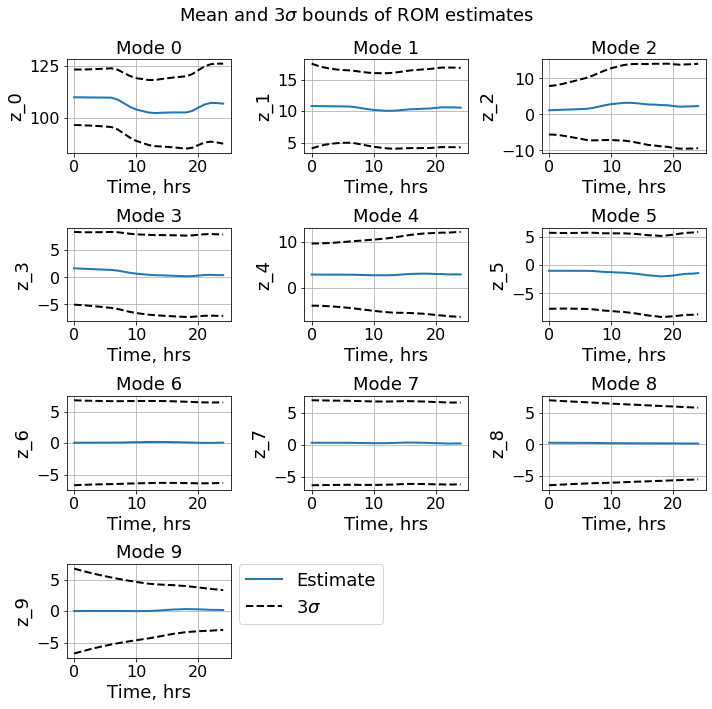

In [15]:
fig, axs = plt.subplots(int(np.ceil(r/3)), 3, figsize=(10, 10))
for ax in axs.flatten():
    ax.set_axis_off()

for ik in range(0,r):
    i = int(ik/3)
    j = ik%3
    axs[i,j].set_axis_on()
    axs[i,j].plot(time/3600,X_est[-r+ik,:], linewidth=2)
    axs[i,j].plot(time/3600,X_est[-r+ik,:]+ 3*Pv[-r+ik,:]**0.5,'--k', linewidth=2)
    axs[i,j].plot(time/3600,X_est[-r+ik,:]- 3*Pv[-r+ik,:]**0.5,'--k', linewidth=2)
    axs[i,j].set_title('Mode %.0f' %ik, fontsize=18)
    axs[i,j].set_xlabel("Time, hrs", fontsize=18)
    axs[i,j].set_ylabel('z_%.0f' %ik, fontsize=18)
    
    axs[i,j].grid('True')
    axs[i,j].tick_params(axis = 'both', which = 'major', labelsize = 16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
axs[i,j].legend(['Estimate','3$\sigma$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=18)
plt.suptitle("Mean and 3$\sigma$ bounds of ROM estimates", fontsize=18)

Text(0.5, 0.98, '3$\\sigma$ of ROM estimates')

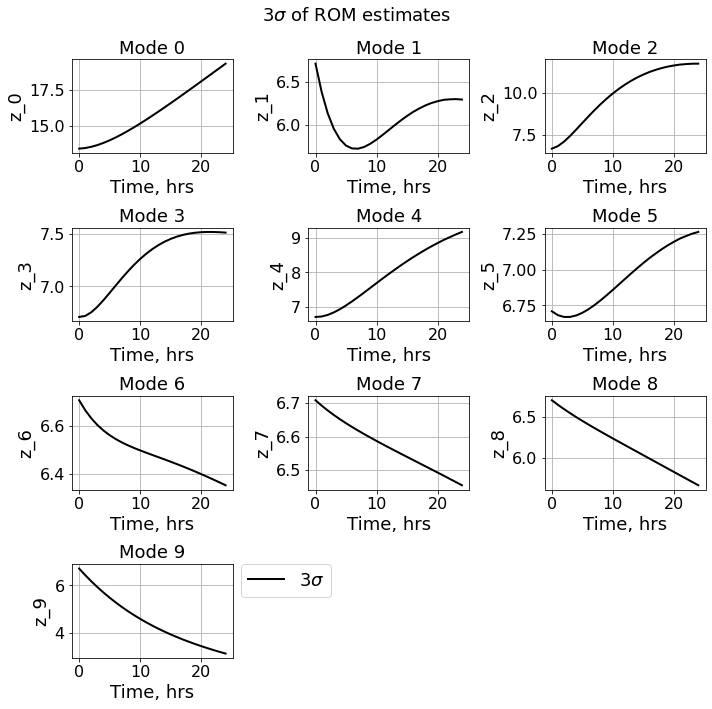

In [16]:
fig, axs = plt.subplots(int(np.ceil(r/3)), 3, figsize=(10, 10))
for ax in axs.flatten():
    ax.set_axis_off()

for ik in range(0,r):
    i = int(ik/3)
    j = ik%3
    axs[i,j].set_axis_on()
    axs[i,j].plot(time/3600,3*Pv[-r+ik,:]**0.5,'k', linewidth=2)
    axs[i,j].set_title('Mode %.0f' %ik, fontsize=18)
    axs[i,j].set_xlabel("Time, hrs", fontsize=18)
    axs[i,j].set_ylabel('z_%.0f' %ik, fontsize=18)
    
    axs[i,j].grid('True')
    axs[i,j].tick_params(axis = 'both', which = 'major', labelsize = 16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
axs[i,j].legend(['3$\sigma$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=18)
plt.suptitle("3$\sigma$ of ROM estimates", fontsize=18)

Text(0.5, 0.98, 'Estimated ballistic coefficients')

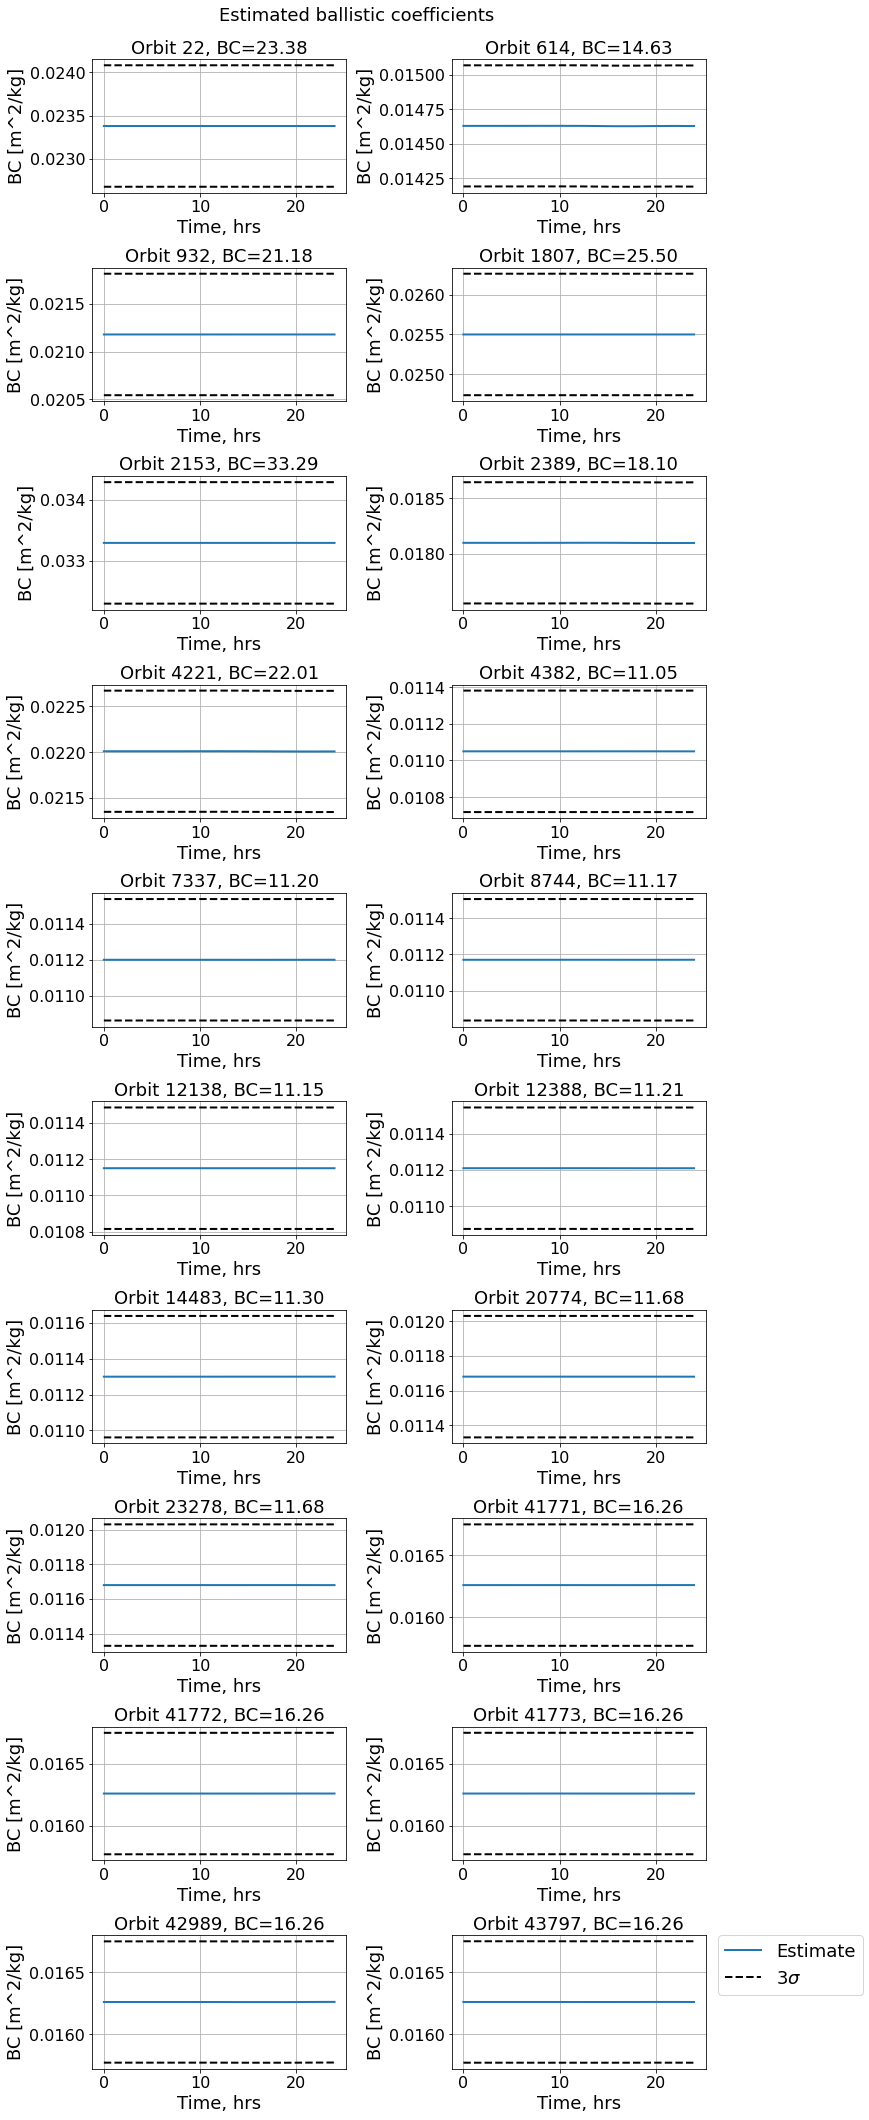

In [17]:
fig, axs = plt.subplots(int(np.ceil(nop/2)), 2, figsize=(10, int(1.5*nop)))
for ax in axs.flatten():
    ax.set_axis_off()

for ik in range(0,nop):
    i = int(ik/2)
    j = ik%2
    axs[i,j].set_axis_on()
    axs[i,j].plot(time/3600,X_est[svs*ik+6,:]/1000, linewidth=2)
    axs[i,j].plot(time/3600,X_est[svs*ik+6,:]/1000+ 3*Pv[svs*ik+6,:]**0.5/1000,'--k', linewidth=2)
    axs[i,j].plot(time/3600,X_est[svs*ik+6,:]/1000- 3*Pv[svs*ik+6,:]**0.5/1000,'--k', linewidth=2)
    axs[i,j].set_title('Orbit %.0f, BC=%.2f' %(objectIDlabels[ik], X_est[svs*ik+6,-1]), fontsize=18)
    axs[i,j].set_xlabel("Time, hrs", fontsize=18)
    axs[i,j].set_ylabel('BC [m^2/kg]', fontsize=18)
    
    axs[i,j].grid('True')
    axs[i,j].tick_params(axis = 'both', which = 'major', labelsize = 16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    
axs[i,j].legend(['Estimate','3$\sigma$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=18)
plt.suptitle("Estimated ballistic coefficients", fontsize=18)

Text(0.5, 0.98, '3$\\sigma$ of estimated ballistic coefficients')

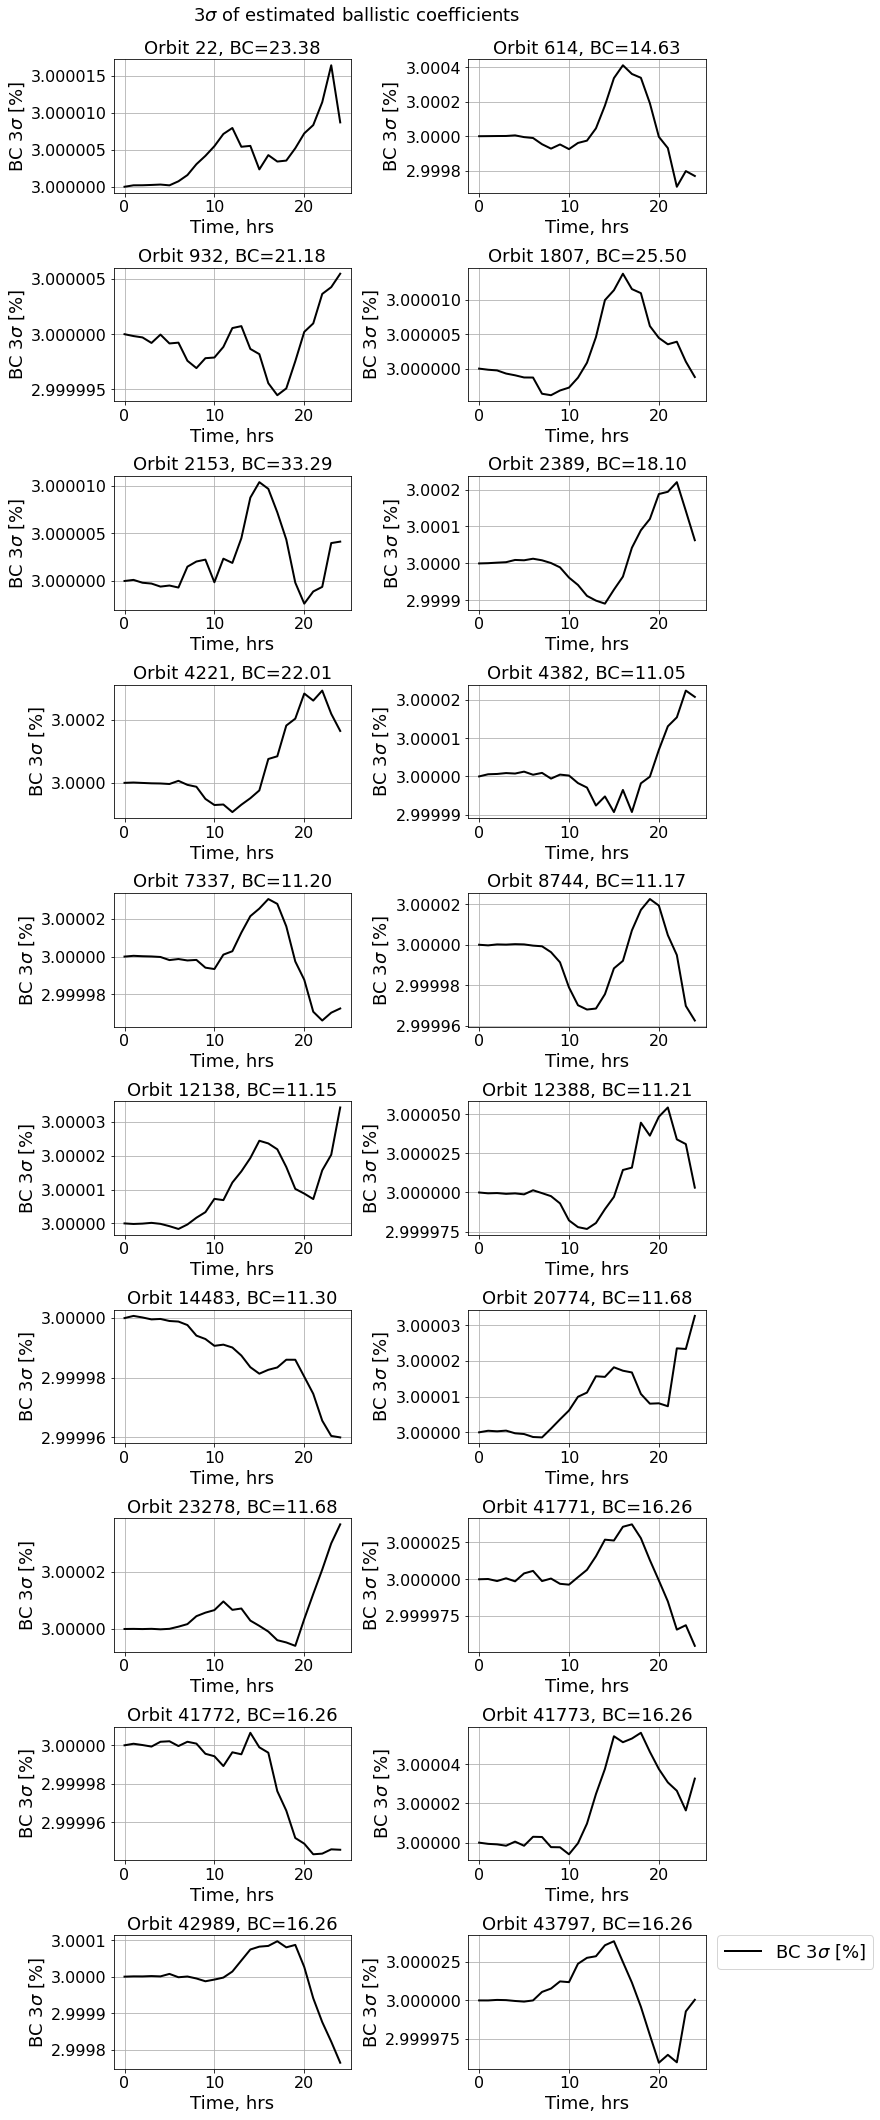

In [18]:
fig, axs = plt.subplots(int(np.ceil(nop/2)), 2, figsize=(10, int(1.5*nop)))
for ax in axs.flatten():
    ax.set_axis_off()

for ik in range(0,nop):
    i = int(ik/2)
    j = ik%2
    axs[i,j].set_axis_on()
    axs[i,j].plot(time/3600,(3*Pv[svs*ik+6,:]**0.5/X_est[svs*ik+6,:]) *100,'k', linewidth=2)
    axs[i,j].set_title('Orbit %.0f, BC=%.2f' %(objectIDlabels[ik], X_est[svs*ik+6,-1]), fontsize=18)
    axs[i,j].set_xlabel("Time, hrs", fontsize=18)
    axs[i,j].set_ylabel('BC 3$\sigma$ [%]', fontsize=18)
    axs[i,j].ticklabel_format(useOffset=False, style='plain')
    
    axs[i,j].grid('True')
    axs[i,j].tick_params(axis = 'both', which = 'major', labelsize = 16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    
axs[i,j].legend(['BC 3$\sigma$ [%]'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=18)
plt.suptitle("3$\sigma$ of estimated ballistic coefficients", fontsize=18)

Text(0.5, 0.98, '3$\\sigma$ bounds of equinoctial obital elements')

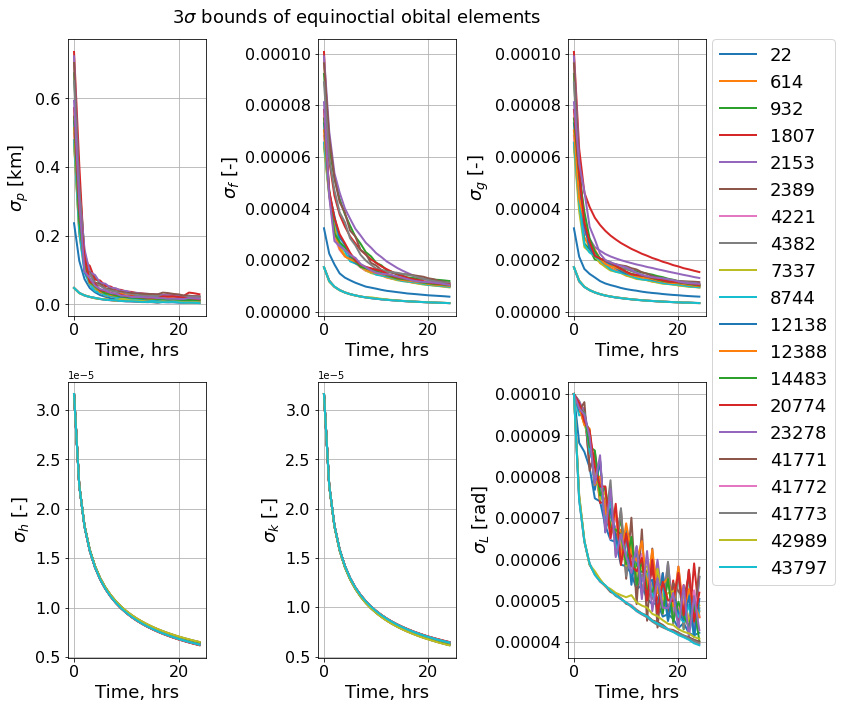

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
for ax in axs.flatten():
    ax.set_axis_off()

for ik in range(0,6):
    i = int(ik/3)
    j = ik%3
    axs[i,j].set_axis_on()
    for ik2 in range(0,nop):
        axs[i,j].plot(time/3600,Pv[svs*ik2+ik,:]**0.5, linewidth=2)
    axs[i,j].set_xlabel("Time, hrs", fontsize=18)
    
    axs[i,j].grid('True')
    axs[i,j].tick_params(axis = 'both', which = 'major', labelsize = 16)

axs[0,0].set_ylabel('$\sigma_p$ [km]', fontsize=18)
axs[0,1].set_ylabel('$\sigma_f$ [-]', fontsize=18)
axs[0,2].set_ylabel('$\sigma_g$ [-]', fontsize=18)
axs[1,0].set_ylabel('$\sigma_h$ [-]', fontsize=18)
axs[1,1].set_ylabel('$\sigma_k$ [-]', fontsize=18)
axs[1,2].set_ylabel('$\sigma_L$ [rad]', fontsize=18)
fig.tight_layout(rect=[0, 0, 1, 0.95])
axs[0,2].legend(objectIDlabels,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=18)
plt.suptitle("3$\sigma$ bounds of equinoctial obital elements", fontsize=18)

Text(0.5, 0.98, 'Position Error')

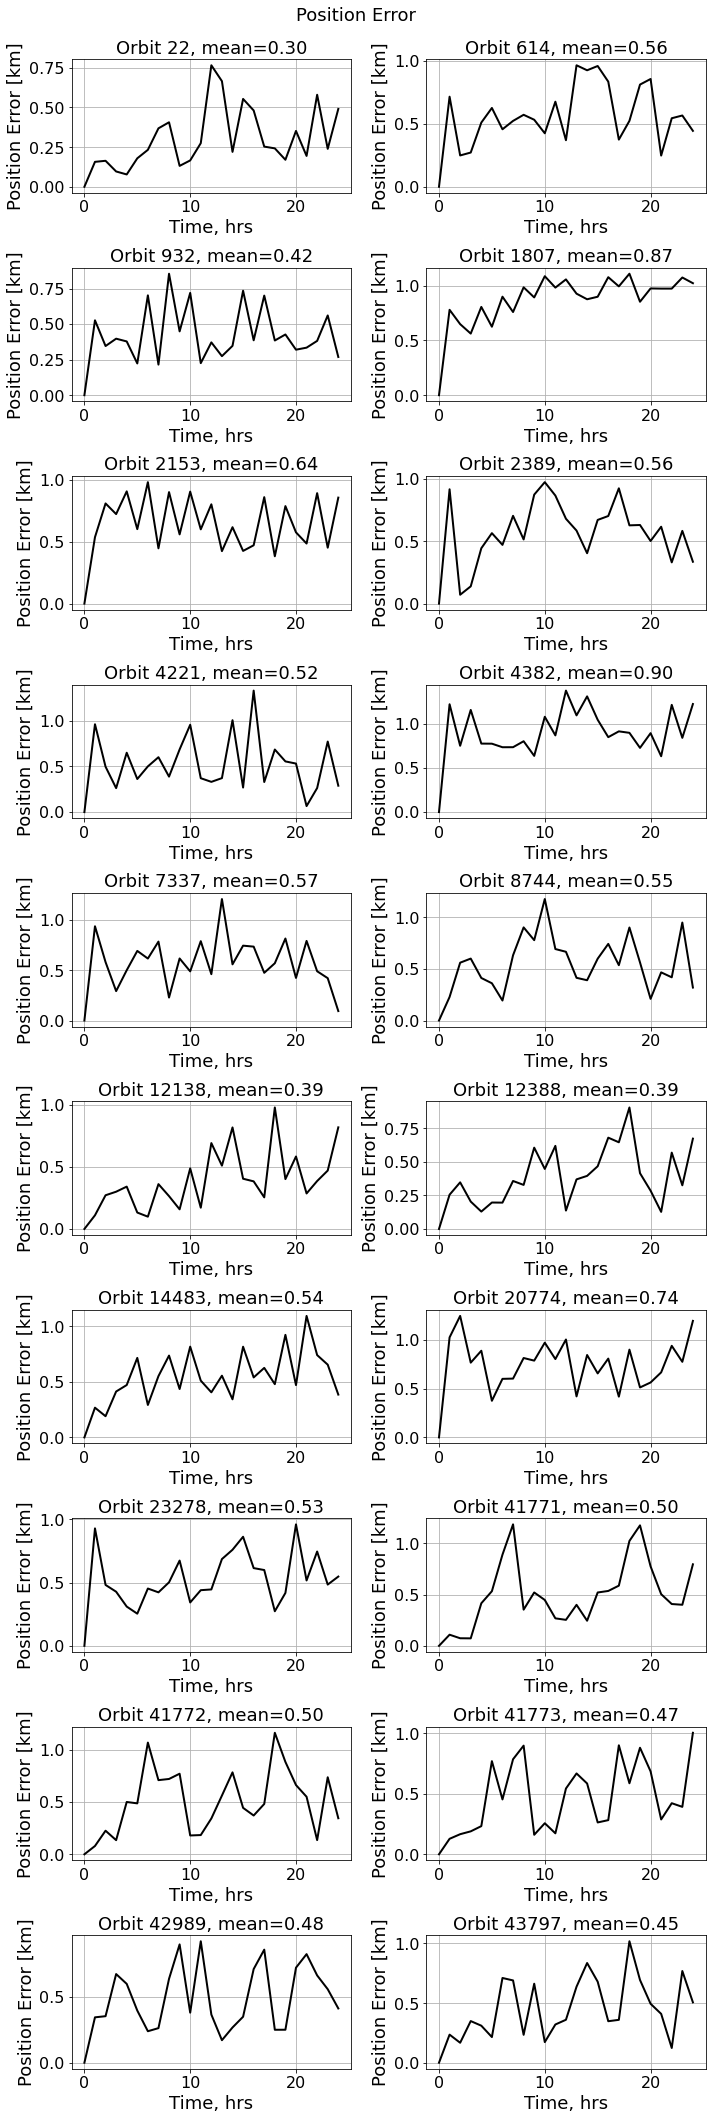

In [20]:
fig, axs = plt.subplots(int(np.ceil(nop/2)), 2, figsize=(10, int(1.5*nop)))
for ax in axs.flatten():
    ax.set_axis_off()

for ik in range(0,nop):
    i = int(ik/2)
    j = ik%2
    
    xx_pv_est = np.zeros_like(X_est);
    xx_pv_meas = np.zeros_like(X_est);
    for ik2 in range (0,X_est.shape[1]):
        pos,vel = ep2pv_jit(X_est[(ik)*svs:(ik)*svs+6,ik2],GM_kms);
        xx_pv_est[0:3,ik2] = pos;
        xx_pv_est[3:6,ik2] = vel;
        pos,vel = ep2pv_jit(meeMeas[(ik)*6:(ik)*6+6,ik2],GM_kms);
        xx_pv_meas[0:3,ik2] = pos;
        xx_pv_meas[3:6,ik2] = vel;
        
    posErrors = np.sqrt(np.sum( (xx_pv_est[0:3,:]-xx_pv_meas[0:3,:]) **2,0));
    
    axs[i,j].set_axis_on()
    axs[i,j].plot(time/3600,posErrors,'k', linewidth=2)
    axs[i,j].set_title('Orbit %.0f, mean=%.2f' %(objectIDlabels[ik], np.mean(posErrors)), fontsize=18)
    axs[i,j].set_xlabel("Time, hrs", fontsize=18)
    axs[i,j].set_ylabel('Position Error [km]', fontsize=18)
    axs[i,j].ticklabel_format(useOffset=False, style='plain')
    
    axs[i,j].grid('True')
    axs[i,j].tick_params(axis = 'both', which = 'major', labelsize = 16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    
plt.suptitle("Position Error", fontsize=18)

Text(0.5, 0, 'Local Time')

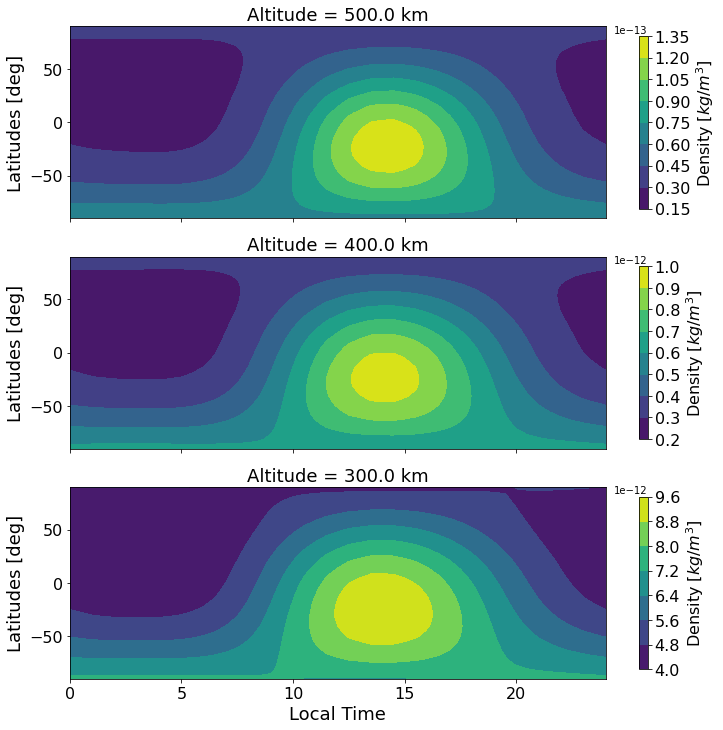

In [21]:
localSolarTimes = np.linspace(0,24,49)
latitudes = np.linspace(-90,90,41)
heights= np.linspace(500,300,3)
SLT = np.tile(localSolarTimes.reshape(-1,1),41)
LAT = np.tile(latitudes.reshape(-1,1),49).T
nofHeights = len(heights)

fig, axs = plt.subplots(nofHeights, figsize=(12, 12), sharex=True)

for i in range (0,nofHeights):
    height = heights[i];
    ALT = height*np.ones_like(SLT);
    rhoVar = np.zeros_like(SLT)
    grid = np.hstack((np.hstack((SLT.reshape(-1,1),LAT.reshape(-1,1))),ALT.reshape(-1,1)))
    for j in range(0,r):
        UhI = F_U[j]((grid)).reshape(SLT.shape);
        rhoVar = rhoVar + UhI*X_est[-r+j,-1];

    MI = M_U((grid)).reshape(SLT.shape);
    rho_rom = 10**(rhoVar+MI);
    # Plot
    cs = axs[i].contourf(localSolarTimes, latitudes, rho_rom.T)
    axs[i].set_title('Altitude = {} km'.format(height), fontsize=18)
    axs[i].set_ylabel("Latitudes [deg]", fontsize=18)
    axs[i].tick_params(axis = 'both', which = 'major', labelsize = 16)
    cbar = fig.colorbar(cs, ax=axs[i], shrink=0.9)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel("Density [$kg/m^3$]", fontsize=16)
axs[i].set_xlabel("Local Time", fontsize=18)

Text(0.5, 0, 'Local Time')

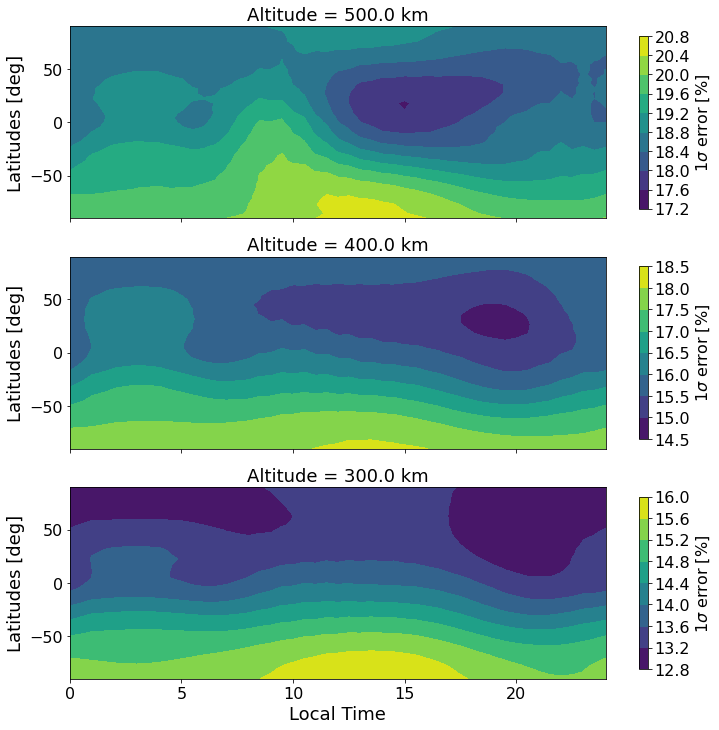

In [22]:
localSolarTimes = np.linspace(0,24,49)
latitudes = np.linspace(-90,90,41)
heights= np.linspace(500,300,3)
SLT = np.tile(localSolarTimes.reshape(-1,1),41)
LAT = np.tile(latitudes.reshape(-1,1),49).T
nofHeights = len(heights)

fig, axs = plt.subplots(nofHeights, figsize=(12, 12), sharex=True)

for i in range (0,nofHeights):
    height = heights[i];
    ALT = height*np.ones_like(SLT);
    H_SL = np.zeros((SLT.size,r));
    grid = np.hstack((np.hstack((SLT.reshape(-1,1),LAT.reshape(-1,1))),ALT.reshape(-1,1)))

    for jk in range(0,r):
        H_SL[:,jk] = F_U[jk]((grid)); # ROM to grid transformation matrix

    Pyy = np.diag((H_SL @ np.diag(Pv[-r:,-1])) @ H_SL.T); # ROM covariance mapped to local solar time and latitude
    Pyyr = Pyy.reshape(SLT.shape); # Convert to matrix
    Pyy1 = 100*Pyyr**0.5*np.log(10); # Convert covariance of log density to standard deviation of density
    # Plot
    cs = axs[i].contourf(localSolarTimes, latitudes, Pyy1.T)
    axs[i].set_title('Altitude = {} km'.format(height), fontsize=18)
    axs[i].set_ylabel("Latitudes [deg]", fontsize=18)
    axs[i].tick_params(axis = 'both', which = 'major', labelsize = 16)
    cbar = fig.colorbar(cs, ax=axs[i], shrink=0.9)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel("1$\sigma$ error [%]", fontsize=16)
        
axs[i].set_xlabel("Local Time", fontsize=18)

Text(0.5, 0.98, 'Equinoctial orbital elements and 3$\\sigma$ bounds')

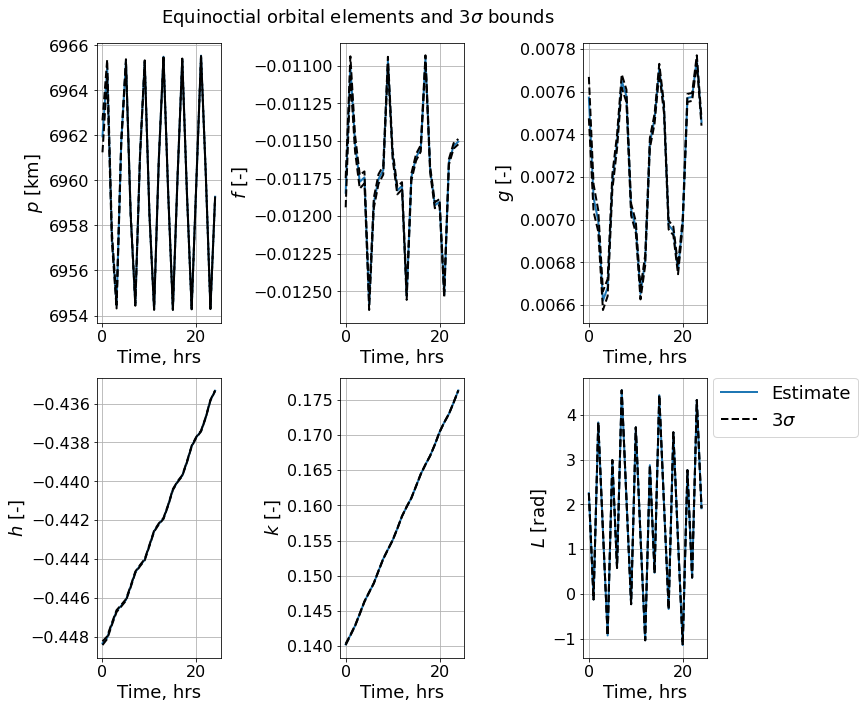

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
for ax in axs.flatten():
    ax.set_axis_off()

for ik in range(0,6):
    i = int(ik/3)
    j = ik%3
    axs[i,j].set_axis_on()
    axs[i,j].plot(time/3600,X_est[ik,:], linewidth=2)
    axs[i,j].plot(time/3600,X_est[ik,:]+ 3*Pv[ik,:]**0.5,'--k', linewidth=2)
    axs[i,j].plot(time/3600,X_est[ik,:]- 3*Pv[ik,:]**0.5,'--k', linewidth=2)
    axs[i,j].set_xlabel("Time, hrs", fontsize=18)
    axs[i,j].set_ylabel('z_%.0f' %ik, fontsize=18)
    
    axs[i,j].grid('True')
    axs[i,j].tick_params(axis = 'both', which = 'major', labelsize = 16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
axs[0,0].set_ylabel('$p$ [km]', fontsize=18)
axs[0,1].set_ylabel('$f$ [-]', fontsize=18)
axs[0,2].set_ylabel('$g$ [-]', fontsize=18)
axs[1,0].set_ylabel('$h$ [-]', fontsize=18)
axs[1,1].set_ylabel('$k$ [-]', fontsize=18)
axs[1,2].set_ylabel('$L$ [rad]', fontsize=18)
axs[i,j].legend(['Estimate','3$\sigma$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=18)
plt.suptitle("Equinoctial orbital elements and 3$\sigma$ bounds", fontsize=18)